### Import libraries

Import the necessary Python libraries. These libraries provide the tools we need to interact with LangGraph, Vertex AI, and other components of our application.

In [1]:
import json
from typing import Literal
import uuid

from google.cloud import storage

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.tools import tool
# from langchain_google_vertexai import ChatVertexAI, VertexAIEmbeddings
from langgraph.graph import END, MessageGraph
from langgraph.prebuilt import ToolNode
import vertexai
from vertexai.preview import reasoning_engines

/Users/azamkhan/.local/lib/python3.11/site-packages/langgraph/checkpoint/base.py:18: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langgraph.serde.jsonplus import JsonPlusSerializer


In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

/Users/azamkhan/anaconda3/envs/museum/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np

from sentence_transformers import SentenceTransformer
import json

model = SentenceTransformer('all-MiniLM-L6-v2')

In [4]:
from pydantic import BaseModel, Field

In [5]:
from langchain_openai import ChatOpenAI
import openai
import os

llm = ChatOpenAI(model="gpt-4o-2024-08-06", api_key=os.environ["OPENAI_API_KEY"])
llm.invoke("Hello, how are you?")

AIMessage(content="Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 13, 'total_tokens': 42, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'stop', 'logprobs': None}, id='run-e3a183de-4ee3-4846-b86e-c79e9ce68c16-0', usage_metadata={'input_tokens': 13, 'output_tokens': 29, 'total_tokens': 42, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI
import os

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=os.environ["GEMINI_API_KEY"])
llm.invoke("Sing a ballad of LangChain.")

AIMessage(content="(Verse 1)\nIn realms of code, where data streams,\nA mighty tool, LangChain gleams.\nTo weave the threads of language bright,\nAnd bring forth knowledge, pure and light.\nFrom scattered texts, a tapestry spun,\nWith chains of thought, its work is done.\n\n(Verse 2)\nThe prompt is given, clear and bold,\nA question asked, a story told.\nThrough LLMs vast, its pathways roam,\nTo find the answers, bring them home.\nWith chains of prompts, it guides the way,\nThrough information's endless sway.\n\n(Verse 3)\nThe memory banks, a faithful friend,\nContext it keeps, until the end.\nEach interaction, neatly stored,\nA conversation, richly poured.\nNo detail lost, no nuance missed,\nA flowing dialogue, it has kissed.\n\n(Verse 4)\nAgents it summons, skilled and keen,\nTo search the web, the unseen scene.\nFrom APIs, it draws its might,\nTo gather facts, and set things right.\nWith tools at hand, it bravely strives,\nTo solve the problems, keep them alive.\n\n(Verse 5)\nBut ch

In [6]:
import faiss
# Load the FAISS index
index = faiss.read_index("paintings_index.faiss")

# Load the JSON metadata
with open("metdata.json", "r") as file:
    data = json.load(file)

paintings = data["paintings"]

## Define the retriever tool

Tools are interfaces that an agent, chain, or LLM can use to enable the Gemini model to interact with external systems, databases, document stores, and other APIs so that the model can get the most up-to-date information or take action with those systems.

In this example, you'll define a function that will retrieve similar documents from the vector store using semantic search.

In [182]:
def index_search(query:str, top_k:int):
    # model = SentenceTransformer('all-MiniLM-L6-v2')
    query_embedding = model.encode([query], convert_to_tensor=False)
    query_embedding = np.array(query_embedding).astype('float32')
    distances, indices = index.search(query_embedding, top_k)  # FAISS search
    result = [paintings[i] for i in indices[0]]
    return result

### State

In [183]:
from typing import Annotated, List, Optional

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages



class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    # visitor_preferences: Optional[VisitorPreferencesManager]
    
    # current_route: Optional[List[str]]

In [202]:
from typing import Dict, List, Optional
import json

from sqlalchemy import create_engine, Column, String, Text
from sqlalchemy.orm import declarative_base, sessionmaker
from sqlalchemy.exc import SQLAlchemyError

from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig

# SQLAlchemy setup
Base = declarative_base()
engine = create_engine('sqlite:///user_preferences.db', echo=False)
Session = sessionmaker(bind=engine)

class UserPreference(Base):
    """
    SQLAlchemy model for storing user preferences
    """
    __tablename__ = 'user_preferences'
    
    user_id = Column(String, primary_key=True)
    art_styles = Column(Text)
    favorite_artists = Column(Text)
    visited_paintings = Column(Text)
    
    def to_dict(self):
        """
        Convert database record to dictionary
        """
        return {
            'art_styles': json.loads(self.art_styles) if self.art_styles else [],
            'favorite_artists': json.loads(self.favorite_artists) if self.favorite_artists else [],
            'visited_paintings': json.loads(self.visited_paintings) if self.visited_paintings else []
        }

class UserPreferencesManager:
    """
    Manager for handling user preferences using SQLAlchemy
    """
    def __init__(self):
        """
        Initialize database tables
        """
        Base.metadata.create_all(engine)
    
    def update_preferences(self, user_id: str, interaction_context: Dict) -> None:
        """
        Update user preferences in the database
        
        Args:
            user_id (str): Unique identifier for the user
            interaction_context (Dict): Details of user's interaction with artworks
        """
        session = Session()
        try:
            # Try to find existing preferences
            user_pref = session.query(UserPreference).get(user_id)
            
            # If no existing preferences, create new record
            if not user_pref:
                user_pref = UserPreference(user_id=user_id)
            
            # Prepare preference sets
            art_styles = set(json.loads(user_pref.art_styles) if user_pref.art_styles else [])
            favorite_artists = set(json.loads(user_pref.favorite_artists) if user_pref.favorite_artists else [])
            visited_paintings = set(json.loads(user_pref.visited_paintings) if user_pref.visited_paintings else [])
            
            # Update preferences
            if 'art_styles' in interaction_context:
                art_styles.add(interaction_context['art_styles'])
            
            if 'favorite_artists' in interaction_context:
                favorite_artists.add(interaction_context['favorite_artists'])
            
            if 'visited_painting' in interaction_context:
                visited_paintings.add(interaction_context['visited_painting'])
            
            # Update record
            user_pref.art_styles = json.dumps(list(art_styles))
            user_pref.favorite_artists = json.dumps(list(favorite_artists))
            user_pref.visited_paintings = json.dumps(list(visited_paintings))
            
            # Add and commit
            session.merge(user_pref)
            session.commit()
        except SQLAlchemyError as e:
            session.rollback()
            print(f"Error updating preferences: {e}")
        finally:
            session.close()
    
    def get_personalized_recommendations(self, user_id: str) -> Dict:
        """
        Generate personalized museum experience recommendations
        
        Args:
            user_id (str): Unique identifier for the user
        
        Returns:
            Dict: Personalized recommendations based on user preferences
        """
        session = Session()
        try:
            # Retrieve user preferences
            user_pref = session.query(UserPreference).get(user_id)
            
            if not user_pref:
                return {
                    'recommended_artworks': [],
                    'recommended_depth': 'basic'
                }
            
            # Parse preferences
            art_styles = json.loads(user_pref.art_styles) if user_pref.art_styles else []
            visited_paintings = json.loads(user_pref.visited_paintings) if user_pref.visited_paintings else []
            
            # Find matching artworks
            matching_artworks = []
            for style in art_styles:
                # results = search_paintings({"query": style, "top_k": 3})
                results = index_search(style, 3)
                matching_artworks.extend(eval(str(results)))
            
            # Determine information depth
            interaction_count = len(visited_paintings)
            depth = 'basic' if interaction_count < 3 else 'intermediate' if interaction_count < 7 else 'expert'
            
            return {
                'recommended_artworks': matching_artworks,
                'recommended_depth': depth
            }
        except SQLAlchemyError as e:
            print(f"Error retrieving recommendations: {e}")
            return {
                'recommended_artworks': [],
                'recommended_depth': 'basic'
            }
        finally:
            session.close()

# Optional cleanup function (SQLAlchemy handles connections differently)
def cleanup():
    """
    Close SQLAlchemy engine if needed
    """
    engine.dispose()

In [203]:
def list_user_preferences(config: RunnableConfig) -> Dict:
    """
    Retrieve user preferences.
    
    Args:
        config (RunnableConfig): Configuration containing user ID.
    
    Returns:
        Dict: User preferences
    """
    user_id = config.get("configurable", {}).get("user_id", "default_user")
    
    session = Session()
    try:
        # Retrieve preferences from database
        user_pref = session.query(UserPreference).get(user_id)
        print("UUUUUUUUU", user_pref)
        return user_pref.to_dict() if user_pref else {}
    except SQLAlchemyError as e:
        print(f"Error retrieving preferences: {e}")
        return {}
    finally:
        session.close()


def _update_user_preferences(preferences: Dict, config: RunnableConfig) -> None:
    """
    Update user preferences based on the user's interactions with the museum's artworks.
    
    Args:
        preferences (Dict): The user's preferences to be updated.
        config (RunnableConfig): Configuration containing user ID.
    """
    user_id = config.get("configurable", {}).get("user_id", "default_user")
    preferences_manager.update_preferences(user_id, preferences)
    print(f"Updated preferences for user {user_id}")

In [ ]:
from typing import List
@tool
def set_user_preferences(art_styles: List, artists: List, config: RunnableConfig) -> None:
    """
    Useful for when you want to update user's favorite art styles and artists.
    """
    preferences = {}
    if art_styles:
        preferences['art_styles'] = art_styles
    if artists:
        preferences['favorite_artists'] = artists
    _update_user_preferences(preferences, config)
    print(f"Set new user preferences")

In [240]:
@tool
def search_related_paintings(painting: str, config: RunnableConfig) -> str:
    """
    Searches for paintings related or similar to the specified painting.
    
    Args:
        painting (str): The title or description of the painting to search for.
        config (RunnableConfig): Configuration containing user ID.
    
    Returns:
        str: Information about related paintings.
    """
    # Search for relevant paintings
    result = index_search(painting, 1)
    result = eval(str(result))
    
    # Update user preferences
    print("Adding new interaction to user preferences", painting)
    _update_user_preferences({
        "art_styles": result[0]['visual_description']['style'], 
        "favorite_artists": result[0]['artist'], 
        'visited_painting': painting
    }, config)

    # Construct related painting info
    related_painting_info = "\n".join(
        [f"Title: {p['painting']}\nArtist: {p['artist']}\nWhy it's related: {p['reason']}" for p in result[0]['related_paintings']]
    )
    return related_painting_info

In [241]:
@tool
def get_personalized_recommendations(config: RunnableConfig) -> Dict:
    """
    Generate personalized museum experience recommendations based on user preferences.
    
    Args:
        config (RunnableConfig): Configuration containing user ID.
    
    Returns:
        Dict: Personalized recommendations based on user preferences.
    """
    user_id = config.get("configurable", {}).get("user_id", "default_user")
    return preferences_manager.get_personalized_recommendations(user_id)

In [242]:
from langchain.agents import Tool
from langchain_community.utilities.wikipedia import WikipediaAPIWrapper

wikipedia_tool = Tool(
    name="wikipedia",
    func=WikipediaAPIWrapper().run,
    description="Useful for when you need to look up and then summarize an artist's biography",
)

In [243]:
class PaintingSearchInput(BaseModel):
    query: str = Field(..., description="Search query for paintings")
    top_k: int = Field(..., description="Number of top results to return")

@tool#(args_schema=PaintingSearchInput)
def search_paintings(query: str, top_k: Optional[int], config: RunnableConfig) -> str:
    """
    Searches the FAISS index for the most relevant paintings based on a user query.

    Args:
        query (str): The user's input query.
        top_k (int): Number of top results to return.
    
    Returns:
        str: A string representation of a list of dictionaries containing painting metadata.
    """
    if top_k is None:
        top_k = 3
    model = SentenceTransformer('all-MiniLM-L6-v2')
    query_embedding = model.encode([query], convert_to_tensor=False)
    query_embedding = np.array(query_embedding).astype('float32')
    distances, indices = index.search(query_embedding, top_k)  # FAISS search
    results = [paintings[i] for i in indices[0]]  # Retrieve painting metadata
    results = str(results)

    
    painting = eval(results)[0]['title']
    print("Adding new interaction to user preferences", painting)
    _update_user_preferences({
        'visited_painting': painting
    }, config)


    return results

In [244]:
class PaintingInfoInput(BaseModel):
    painting: str = Field(..., description="The painting to get information about.")

@tool#(args_schema=PaintingInfoInput)
def getPaintingInfo(painting: str, config: RunnableConfig) -> str:
    """
    Searches for a painting by its title and then returns data about the painting such as the artist, description, things to mention, and expert knowledge.

    Args:
        painting (str): The title of the painting to search for.

    Returns:
        str: A string representation of a dictionary containing painting metadata.
    """
    # model = SentenceTransformer('all-MiniLM-L6-v2')
    # query_embedding = model.encode([painting], convert_to_tensor=False)
    # query_embedding = np.array(query_embedding).astype('float32')
    # distances, indices = index.search(query_embedding, 1)  # FAISS search
    # result = [paintings[i] for i in indices[0]]
    result = index_search(painting, 1)

    # update user preferences since they like this painting
    print("Adding new interaction to user preferences", painting)
    _update_user_preferences({
        "art_styles": result[0]['visual_description']['style'], 
        "favorite_artists": result[0]['artist'], 
        'visited_painting': painting
    }, config)


    painting_info = {}
    painting_info['artist'] = result[0]['artist']
    painting_info['year'] = result[0]['year']
    painting_info['things_to_mention'] = result[0]['things_to_mention']
    painting_info['expert_insights'] = result[0]['expert_knowledge']
    painting_info['conversational_prompts'] = result[0]['narrative']['conversational_prompts']
    painting_info['style'] = result[0]['visual_description']['style']
    

    return str(painting_info)

## Define LangGraph application

Now you'll bring everything together to define your LangGraph application as a custom template in Reasoning Engine.

This application will use the tool and router that you just defined. LangGraph provides a powerful way to structure these interactions and leverage the capabilities of LLMs.

In [245]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    """
    Creates a ToolNode with the provided tools and sets up a fallback mechanism.

    This function initializes a ToolNode with the given list of tools and configures
    it to use a fallback handler in case of errors. The fallback handler is a 
    RunnableLambda that executes the handle_tool_error function.

    Args:
        tools (list): A list of tools to be included in the ToolNode.

    Returns:
        dict: A ToolNode object with the specified tools and fallback mechanism.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [246]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


preferences_manager = UserPreferencesManager()

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable
        # preferences_manager = UserPreferencesManager()

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            result = self.runnable.invoke(state)
            state = {**state, "user_preferences": configuration}

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful museum tour guide. "
            " Use the provided tools to search for paintings, related paintings, and other information to assist the user's queries. "
            " Spark conversation with the user by utilising the conversational prompts provided by the tools if they are returned. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up.",
        ),
        ("placeholder", "{messages}"),
    ]
)

part_1_tools = [
    search_paintings,
    search_related_paintings,
    getPaintingInfo,
    wikipedia_tool,
    get_personalized_recommendations,
    set_user_preferences,
]

part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

In [247]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition


builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
part_1_graph = builder.compile(checkpointer=memory)

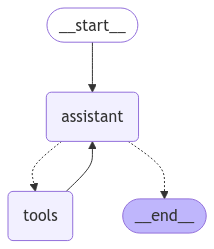

In [248]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [249]:
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "user_id": thread_id,
        "user_preferences": {
            'art_styles': [],
            'favorite_artists': [],
            'interaction_depth': 0,
            'visited_paintings': [],
            'default_user' : "user_1"
        },
        "thread_id": thread_id,
    }
}

_printed = set()
questions = [
    "What painting is the one with three girls in red dresses peeling potatoes?",
    "What painting is the one where a woman is making another woman's hair and there is a child in the foreground?",
    "I like the art style Realism, and my favorite artist is Leonardo da Vinci", 
    "Tell me about a similar painting and how to find it from this painting.",
    "And can you tell me about the artist who painted this one?",
    "Can you give me some further info about this painting and maybe also some expert insights?",
    "I like this painting, can you give me a personalized recommendation of other paintings to look at, based on my preferences?",

    
]
for question in questions:
    events = part_1_graph.stream(
            {"messages": ("user", question)}, config, stream_mode="values"
        )

    for event in events:
        _print_event(event, _printed)
        # print(event)


================================ Human Message =================================

What painting is the one with three girls in red dresses peeling potatoes?


ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.tools[0].function_declarations[5].parameters.properties[art_style].items: missing field.
* GenerateContentRequest.tools[0].function_declarations[5].parameters.properties[artists].items: missing field.


In [397]:
import requests
import json
from pprint import pprint

def get_art(objectID):
    url = f"https://collectionapi.metmuseum.org/public/collection/v1/objects/{objectID}"
    response = requests.get(url)
    data = response.json()
    return data

obj = (get_art(700414)) # 1930
pprint(obj)

{'message': 'Not a valid object'}


In [35]:
import sqlite3

In [225]:
def create_connection(db_file): 
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Exception as e:
        print(e)
    return conn

# search all users in user_preferences table

def select_all_users(conn):
    cur = conn.cursor()
    cur.execute("SELECT * FROM user_preferences")
    rows = cur.fetchall()
    for row in rows:
        print(row)

select_all_users(create_connection("user_preferences.db"))

# delete all rows in user_preferences table

# def delete_all_users(conn):
#     cur = conn.cursor()
#     cur.execute("DELETE FROM user_preferences")
#     conn.commit()

# delete_all_users(create_connection("user_preferences.db"))

('8f58da0f-7dd9-4c39-b253-b2edfad61e9a', '["Realism"]', '["Leon Frederic"]', '["The Three Sisters"]')
('703b2559-2733-452e-b02a-e3dafc1c9357', '["Rose Period"]', '["Pablo Picasso"]', '["La Coiffure"]')
('a923787e-e589-4549-8b39-ad8fd2701880', '["Rose Period"]', '["Pablo Picasso"]', '["La Coiffure", "The Three Sisters"]')
('896d680e-81ea-470c-8835-60d28c1b1e34', '["Rose Period"]', '["Pablo Picasso"]', '["La Coiffure", "The Three Sisters"]')
('115177dd-6ee0-4140-913e-2c37dbc631c5', '[]', '[]', '["La Coiffure", "The Three Sisters"]')
('a838fed3-1f9c-4169-bf76-a5a51a559c56', '["Rose Period"]', '["Pablo Picasso"]', '["The Three Sisters", "La Coiffure"]')
